In [1]:
import nltk
from nltk.corpus import brown
import numpy as np
from sklearn.model_selection import KFold
from gensim.models import Word2Vec
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score


In [2]:
def OneHotEncoder(tag, total_tag):
    return np.eye(total_tag)[tag]

In [3]:
def featureExtractor(word_id, sample, word2vec,tags):
    feature_vector = []
    vocab = word2vec.wv.vocab.keys()
    #Add word2vec embedding of current and previous word
    no_of_prev_words = 1
    for idx in reversed(range(0,no_of_prev_words+1)):
        if sample[word_id-idx][0] not in vocab:
            feature_vector.append(np.zeros(word2vec.vector_size))
        else:
            feature_vector.append(word2vec[sample[word_id-idx][0]])

    #Add word2vec embedding of next word
    no_of_next_words = 1
    for idx in range(1,no_of_next_words+1):
        if sample[word_id+idx][0] not in vocab:
            feature_vector.append(np.zeros(word2vec.vector_size))
        else:
            feature_vector.append(word2vec[sample[word_id+idx][0]])
    #Add one-hot embedding of previous 3 tags
    no_of_prev_tags = 3
    for idx in reversed(range(1,no_of_prev_tags+1)):
        tag = sample[word_id-idx][1]
        feature_vector.append(OneHotEncoder(tags.index(tag),len(tags)))

    #Set the bit if word has verb prefix
    if len(sample[word_id][0]) > 4:
        if sample[word_id][0][:5].lower() in ["trans"] or sample[word_id][0][:4].lower() in ["over","fore"] or sample[word_id][0][:3].lower() in ["mis","out","pre","sub"] or sample[word_id][0][:2].lower() in ["un","be","de"]:
            feature_vector.append([1])
        else: 
            feature_vector.append([0])
    else:
        feature_vector.append([0])
    
    #Set the bit if word has verb suffix
    if len(sample[word_id][0]) > 4:
        if sample[word_id][0][-3:].lower() in ["ise","ate"] or sample[word_id][0][-2:].lower() in ["fy","en"]:
            feature_vector.append([1])
        else: 
            feature_vector.append([0])
    else:
        feature_vector.append([0])

    #Set the bit if word has noun prefix
    if len(sample[word_id][0]) > 4:
        if sample[word_id][0][:5].lower() in ["hyper","super","ultra"] or sample[word_id][0][:4].lower() in ["anti","semi","auto","kilo","mega","mini","mono","poly"] or sample[word_id][0][:3].lower() in ["mis","out","sub"] or sample[word_id][0][:2].lower() in ["bi","in"]:
            feature_vector.append([1])
        else: 
            feature_vector.append([0])
    else:
        feature_vector.append([0])
    
    #Set the bit if word has noun suffix
    if len(sample[word_id][0]) > 4:
        if sample[word_id][0][-4:].lower() in ["tion","sion","ment","ance","ence","ship","ness"] or sample[word_id][0][-3:].lower() in ["ism","ity","ant","ent","age","ery"] or sample[word_id][0][-2:].lower() in ["ry","al","er","cy"]:
            feature_vector.append([1])
        else: 
            feature_vector.append([0])
    else:
        feature_vector.append([0])

    #Set the bit if word has adjective prefix
    if len(sample[word_id][0]) > 4:
        if sample[word_id][0][:3].lower() in ["non"] or sample[word_id][0][:2].lower() in ["im","in","ir",'il']:
            feature_vector.append([1])
        else: 
            feature_vector.append([0])
    else:
        feature_vector.append([0])
    
    #Set the bit if next word has adjective suffix
    if len(sample[word_id][0]) > 4:
        if sample[word_id][0][-4:].lower() in ["able","less"] or sample[word_id][0][-3:].lower() in ["ive","ous","ful"] or sample[word_id][0][-2:].lower() in ["al"]:
            feature_vector.append([1])
        else: 
            feature_vector.append([0])
    else:
        feature_vector.append([0])

    #Set the bit if next word has verb prefix
    if len(sample[word_id+1][0]) > 4:
        if sample[word_id+1][0][:5].lower() in ["trans"] or sample[word_id+1][0][:4].lower() in ["over","fore"] or sample[word_id+1][0][:3].lower() in ["mis","out","pre","sub"] or sample[word_id+1][0][:2].lower() in ["un","be","de"]:
            feature_vector.append([1])
        else: 
            feature_vector.append([0])
    else:
        feature_vector.append([0])
    
    #Set the bit if next word has verb suffix
    if len(sample[word_id+1][0]) > 4:
        if sample[word_id+1][0][-3:].lower() in ["ise","ate"] or sample[word_id+1][0][-2:].lower() in ["fy","en"]:
            feature_vector.append([1])
        else: 
            feature_vector.append([0])
    else:
        feature_vector.append([0])

    #Set the bit if next word has noun prefix
    if len(sample[word_id+1][0]) > 4:
        if sample[word_id+1][0][:5].lower() in ["hyper","super","ultra"] or sample[word_id+1][0][:4].lower() in ["anti","semi","auto","kilo","mega","mini","mono","poly"] or sample[word_id+1][0][:3].lower() in ["mis","out","sub"] or sample[word_id+1][0][:2].lower() in ["bi","in"]:
            feature_vector.append([1])
        else: 
            feature_vector.append([0])
    else:
        feature_vector.append([0])
    
    #Set the bit if next word has noun suffix
    if len(sample[word_id+1][0]) > 4:
        if sample[word_id+1][0][-4:].lower() in ["tion","sion","ment","ance","ence","ship","ness"] or sample[word_id+1][0][-3:].lower() in ["ism","ity","ant","ent","age","ery"] or sample[word_id+1][0][-2:].lower() in ["ry","al","er","cy"]:
            feature_vector.append([1])
        else: 
            feature_vector.append([0])
    else:
        feature_vector.append([0])

    #Set the bit if next word has adjective prefix
    if len(sample[word_id+1][0]) > 4:
        if sample[word_id+1][0][:3].lower() in ["non"] or sample[word_id+1][0][:2].lower() in ["im","in","ir",'il']:
            feature_vector.append([1])
        else: 
            feature_vector.append([0])
    else:
        feature_vector.append([0])
    
    #Set the bit if next word has adjective suffix
    if len(sample[word_id+1][0]) > 4:
        if sample[word_id+1][0][-4:].lower() in ["able","less"] or sample[word_id+1][0][-3:].lower() in ["ive","ous","ful"] or sample[word_id+1][0][-2:].lower() in ["al"]:
            feature_vector.append([1])
        else: 
            feature_vector.append([0])
    else:
        feature_vector.append([0])


    #Set the bit if it is starting of sample
    if word_id ==0:
      feature_vector.append([1])
    else:
        feature_vector.append([0])

    #Set the bit if it is ending of sample
    if word_id == len(sample)-1:
      feature_vector.append([1])
    else:
        feature_vector.append([0])
      
    #Set the bit if  all letter of word are capital
    if sample[word_id][0].upper() == sample[word_id][0]:
      feature_vector.append([1])
    else:
        feature_vector.append([0])

    #Set the bit if all letter of word are small
    if sample[word_id][0].lower() == sample[word_id][0]:
      feature_vector.append([1])
    else:
        feature_vector.append([0])
      
    #Set the bit if first letter of word is capital   
    if sample[word_id][0][0].isupper():
        feature_vector.append([1])
    else:
        feature_vector.append([0])

    #Set the bit if letters other than 1st letter are capital
    if sample[word_id][0][1:].lower() != sample[word_id][0][1:]:
      feature_vector.append([1])
    else:
        feature_vector.append([0])
      
    #Set the bit if word is numeric
    if sample[word_id][0].isdigit():
      feature_vector.append([1])
    else:
        feature_vector.append([0])
    
    #Set the bit if word contains a "-"
    if '-' in sample[word_id][0]:
      feature_vector.append([1])
    else:
        feature_vector.append([0])

    flat_list = [item for sublist in feature_vector for item in sublist]
    return flat_list


In [4]:
class SVM:

    def __init__(self):
        self.W = None 

    def train(self, X, y, batch_size=200, lr=1e-3, regularization = 1e1):
        
        total_tags = np.max(y) + 1

        if self.W is None:
          self.W = np.random.normal(0,1, size=(total_tags, X.shape[0]))

        losses_history = []

        for i in range(0,X.shape[1], batch_size):
            loss, grad = self.calculate_gradient(X[:, i:i+batch_size], y[i:i+batch_size], regularization ) 
            losses_history.append(loss)
            self.W -= lr * grad
        return losses_history

    def calculate_gradient(self, X, y, regularization):
      W=self.W
      dW = np.zeros(W.shape)
      loss = 0.0
      delta = 1.0

      batch_size = y.shape[0]
      y_values = W.dot(X)
      y_values_true = y_values[y, range(batch_size)] 
      
      y_margin = y_values - y_values_true + delta
      y_margin = np.maximum(0, y_margin)
      y_margin[y, range(batch_size)] = 0

      loss = np.sum(y_margin) / batch_size + 0.5 * regularization * np.sum(W * W)

      y_grad = np.zeros(y_values.shape)
      y_incorrect_count = np.sum(y_margin > 0, axis=0)
      y_grad[y_margin > 0] = 1
      y_grad[y, range(batch_size)] = -1 * y_incorrect_count

      dW = y_grad.dot(X.T) / batch_size + regularization * W
      return loss, dW
    
    def predict(self, X):
        return np.argmax(self.W.dot(X), axis=0)


In [5]:
def pos_tagger(text,model):
  sample=[]
  for i in text.split():
    sample.append([i,"X"])
  sample = [["","<^>"],["","<^>"]] + sample + [["","<$>"]]
  for j in range(2,len(sample)-1):
    x=[featureExtractor(j, sample, w2v_mapping, tags_list)]
    inp=np.array(x).astype(np.float).T
    y_pred = model.predict(inp)
    sample[j][1]=tags_list[y_pred[0]]
  return sample[2:-1]

In [6]:
nltk.download('brown')
nltk.download('universal_tagset')
dataset_sentances = brown.sents()
dataset_tagged = brown.tagged_sents(tagset = 'universal')
w2v_mapping = Word2Vec(dataset_sentances, size=50)
print("Universal Tags :")
tags_set = list(set([tag for (_, tag) in brown.tagged_words(tagset='universal')]))
tags_set.extend(["<^>","<$>"])
print(tags_set)
tags_set.sort()
tags={}
for i,tag in enumerate(tags_set):
  tags[tag]=i
tags_list = list(tags_set)
print("Extracting Features")
X_dataset=[]
Y_dataset=[]
for sample in tqdm(dataset_tagged):
    sample = [("","<^>"),("","<^>"),("","<^>")] + sample + [("","<$>")]
    for j in range(3,len(sample)-1):
        X_dataset.append(featureExtractor(j, sample, w2v_mapping, tags_list))
        Y_dataset.append(tags[sample[j][1]])
X_dataset=np.array(X_dataset).astype(np.float)
Y_dataset=np.array(Y_dataset)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
Universal Tags :
['.', 'ADJ', 'VERB', 'DET', 'ADP', 'CONJ', 'NUM', 'NOUN', 'X', 'ADV', 'PRT', 'PRON', '<^>', '<$>']
Extracting Features


100%|██████████| 57340/57340 [01:36<00:00, 594.47it/s]


In [53]:
print("Traing POS-TAGGER")
model = SVM()
epoch=30
crosss_validator = KFold(n_splits=5, random_state=42, shuffle=False)
for i in range(epoch):
  epoch_accuracy=[]
  epoch_loss=[]
  for train_index, test_index in crosss_validator.split(X_dataset):
    X_train, X_test, y_train, y_test = X_dataset[train_index], X_dataset[test_index], Y_dataset[train_index], Y_dataset[test_index]
    loss = model.train(X_train.T, y_train, batch_size=256, lr=0.01,regularization = 0.0001)
    epoch_loss.extend(loss)
    y_pred = model.predict(X_test.T)
    epoch_accuracy.append(np.mean(y_test == y_pred))
  print ('epoch no : %d  accuracy: %f  loss: %f' % (i+1,np.mean(epoch_accuracy),np.mean(epoch_loss)) )


Traing POS-TAGGER
epoch no : 1  accuracy: 0.829588  loss: 2.228406
epoch no : 2  accuracy: 0.871133  loss: 0.792536
epoch no : 3  accuracy: 0.882942  loss: 0.652065
epoch no : 4  accuracy: 0.889213  loss: 0.583165
epoch no : 5  accuracy: 0.893243  loss: 0.540587
epoch no : 6  accuracy: 0.896336  loss: 0.511628
epoch no : 7  accuracy: 0.898545  loss: 0.490708
epoch no : 8  accuracy: 0.900042  loss: 0.474895
epoch no : 9  accuracy: 0.901300  loss: 0.462493
epoch no : 10  accuracy: 0.902294  loss: 0.452479
epoch no : 11  accuracy: 0.903101  loss: 0.444214
epoch no : 12  accuracy: 0.903708  loss: 0.437251
epoch no : 13  accuracy: 0.904188  loss: 0.431262
epoch no : 14  accuracy: 0.904585  loss: 0.426048
epoch no : 15  accuracy: 0.904898  loss: 0.421458
epoch no : 16  accuracy: 0.905174  loss: 0.417379
epoch no : 17  accuracy: 0.905392  loss: 0.413728
epoch no : 18  accuracy: 0.905542  loss: 0.410437
epoch no : 19  accuracy: 0.905742  loss: 0.407448
epoch no : 20  accuracy: 0.905925  loss: 

Accuracy is :  90.72151719956733
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    147565
           2       0.00      0.00      0.00         0
           3       0.77      0.66      0.71     83721
           4       0.95      0.95      0.95    144766
           5       0.82      0.60      0.69     56239
           6       0.99      0.97      0.98     38151
           7       0.99      0.99      0.99    137019
           8       0.86      0.93      0.89    275558
           9       0.93      0.87      0.90     14874
          10       0.98      0.95      0.97     49334
          11       0.85      0.87      0.86     29829
          12       0.87      0.89      0.88    182750
          13       0.84      0.47      0.60      1386

    accuracy                           0.91   1161192
   macro avg       0.83      0.78      0.80   1161192
weighted avg       0.91      0.91      0.91   1161192

Confusion Matrix


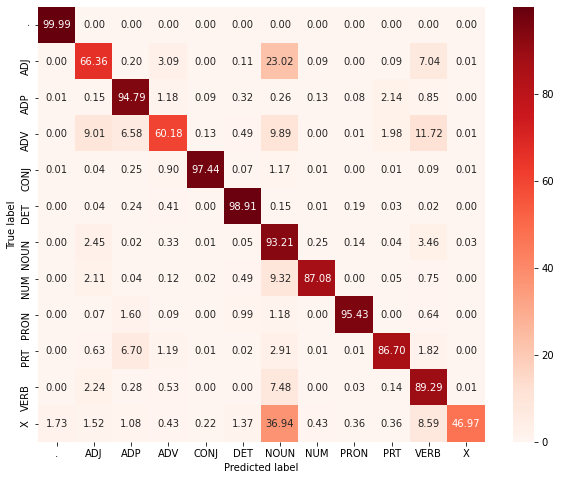

In [60]:
predicted_tag=[]
true_tag=[]
for train_index, test_index in crosss_validator.split(X_dataset):
    X_train, X_test, y_train, y_test = X_dataset[train_index], X_dataset[test_index], Y_dataset[train_index], Y_dataset[test_index]
    X_test=np.transpose(X_test)
    y_pred = model.predict(X_test)
    predicted_tag.extend(y_pred)
    true_tag.extend(y_test)

print("Accuracy is : ",accuracy_score(true_tag, predicted_tag)*100)
print("Classification report")
print(classification_report(true_tag, predicted_tag))
print("Confusion Matrix")
cm_df = pd.DataFrame(confusion_matrix(true_tag, predicted_tag,labels=range(14)),index = tags_list, columns =tags_list)
cm_df.drop(columns=["<$>","<^>"],inplace=True)
cm_df.drop(["<$>","<^>"],inplace=True)
cm_df=cm_df.div(cm_df.sum(axis=1)*0.01, axis=0).fillna(0)
plt.figure(figsize=(10,8))
ax=sns.heatmap(cm_df, annot=True ,fmt=".2f", cmap="Reds")
ax.set_ylim(12, 0)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

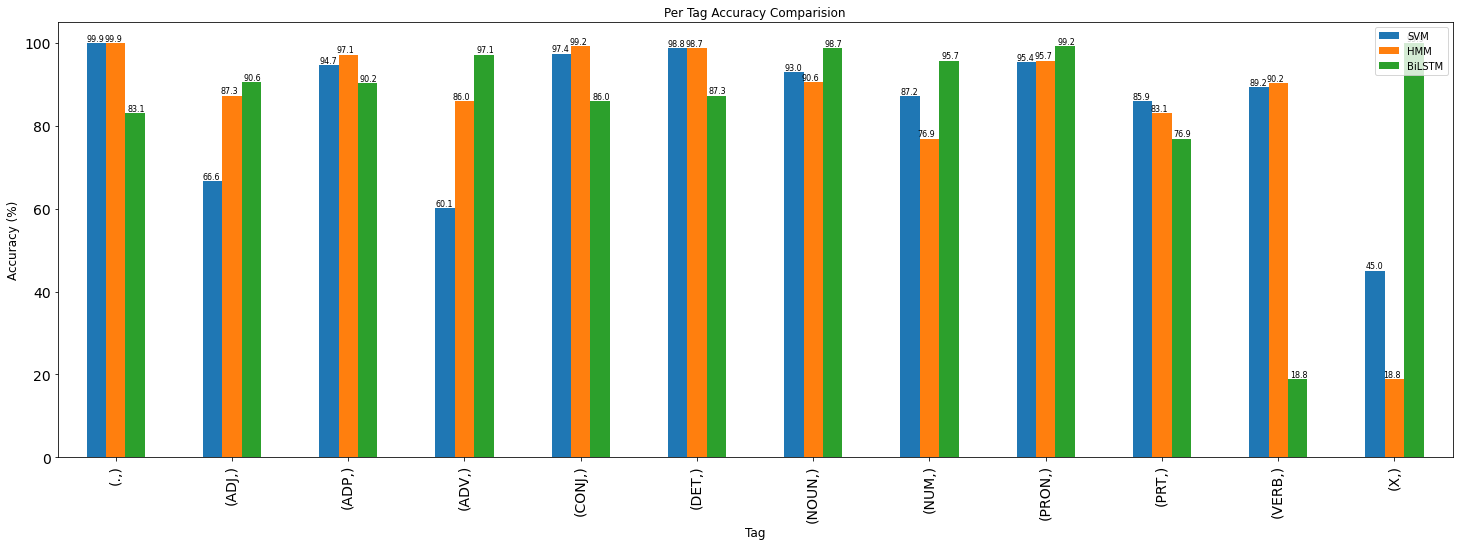

In [28]:
# print("Per Tag Accuracy Comparision")
hmm_per_class=[99.977626,87.330441,97.196992, 86.039065,99.281085,98.716235,90.614809,76.914278, 95.758399,83.165028,90.286143,18.84058 ]
bilstm_per_class=[83.165028, 90.614809, 90.286143, 97.196992, 86.039065, 87.330441, 98.716235, 95.758399, 99.281085, 76.914278,18.84058 , 99.977626]

per_class_accuracy=pd.DataFrame(np.diag(cm_df), index=[cm_df.index])
per_class_accuracy["SVM"]=per_class_accuracy[0]
per_class_accuracy["HMM"]=hmm_per_class
per_class_accuracy["BiLSTM"]=bilstm_per_class
ax = per_class_accuracy[['SVM','HMM',"BiLSTM"]].plot(kind='bar', title ="Per Tag Accuracy Comparision", figsize=(25, 8), fontsize=14,legend=True)
for i, v in enumerate(list(per_class_accuracy['SVM'])):
    plt.text(i - 0.25, v + 0.5, str(v)[:4], fontsize=8)
for i, v in enumerate(list(per_class_accuracy['HMM'])):
    plt.text(i - 0.10, v + 0.5, str(v)[:4], fontsize=8)
for i, v in enumerate(list(per_class_accuracy['BiLSTM'])):
    plt.text(i + 0.10, v + 0.5, str(v)[:4], fontsize=8)
ax.set_xlabel("Tag", fontsize=12)
ax.set_ylabel("Accuracy (%)", fontsize=12)
# ax.tight_layout()
plt.show()

In [10]:
# for i in range(14):
#   print((cm_df.to_numpy()[i][i]+cm_df.to_numpy().sum()-cm_df.to_numpy().sum(axis=0)[i])/cm_df.to_numpy().sum())

0.9985451833081237
0.983016043070215
0.9839924211499895
0.9936840419580771
0.9996068787844365
0.9962044963411426
0.9088184046653117
0.9984820477314311
0.9993554371092328
0.9957367927903364
0.9642341018120865
0.9999845863420955


IndexError: ignored

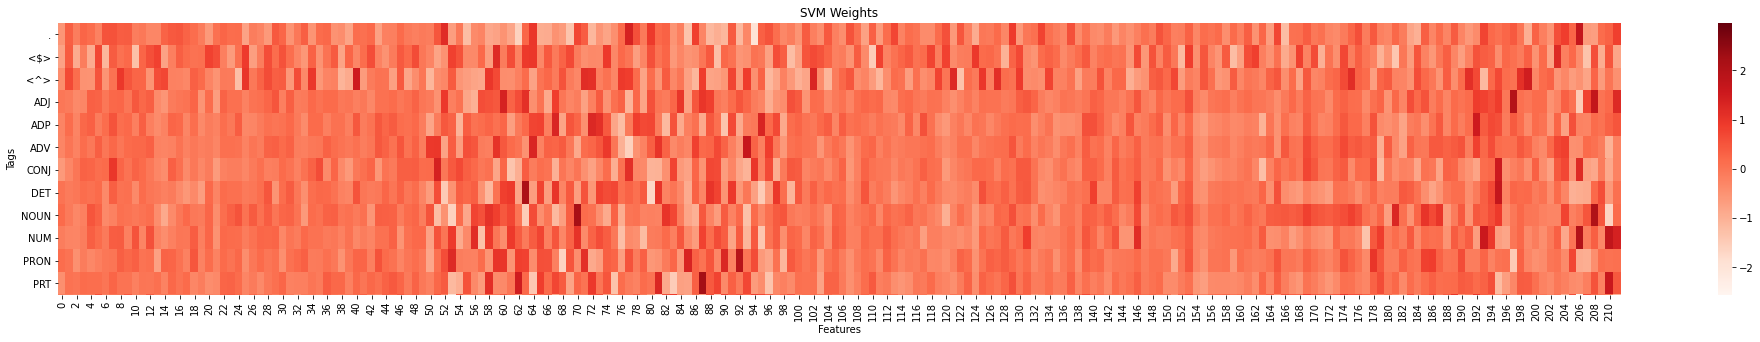

In [65]:
# %matplotlib inline
plt.figure(figsize=(35,5))
ax=sns.heatmap(model.W, annot=False , cmap="Reds",yticklabels=tags_list)
plt.title('SVM Weights')
ax.set_ylim(12, 0)
plt.ylabel('Tags')
plt.xlabel('Features')
plt.show()

In [45]:

for i in pos_tagger(" Fears prejudicial aspects",model):
  print(i[0],"->",i[1])

Fears -> ADV
prejudicial -> ADJ
aspects -> NOUN
